In [3]:
%load_ext autoreload
%autoreload 2
from autoseg.datasets import get_dataset_path
from autoseg.config import read_config
from autoseg.models import Model
import zarr
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import functools
import gunpowder as gp
from gunpowder.nodes.add_affinities import seg_to_affgraph
from autoseg.datasets import GunpowderZarrDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dataloader_from_config(dataset, config):
    if config["parallel"]:
        if config["use_gunpowder_precache"]:
            import gunpowder as gp

            dataset.pipeline += gp.PreCache(
                num_workers=config["num_workers"],
                cache_size=config["precache_per_worker"] * config["num_workers"],
            )
            return DataLoader(
                dataset=dataset,
                collate_fn=collate,
                pin_memory=False,
            )

        return DataLoader(
            dataset=dataset,
            collate_fn=collate,
            batch_size=config["batch_size"],
            num_workers=config["num_workers"],
            prefetch_factor=config["precache_per_worker"],
            pin_memory=False,
        )
    else:
        return DataLoader(
            dataset=dataset,
            collate_fn=collate,
            batch_size=config["batch_size"],
            pin_memory=False,
        )

In [45]:
config = read_config("autoseg/examples/lsd")
dataset = GunpowderZarrDataset(
  config=config["pipeline"],
  input_image_shape=(40, 1000, 1000),
  output_image_shape=(40, 1000, 1000)
)

/home/anton/.cache/autoseg/datasets/SynapseWeb/kh2015/data/apical.zarr.zip labels/s0
/home/anton/.cache/autoseg/datasets/SynapseWeb/kh2015/data/apical.zarr.zip labels_mask/s0
/home/anton/.cache/autoseg/datasets/SynapseWeb/kh2015/data/apical.zarr.zip raw/s0


In [46]:
dataset_iter = iter(dataset)
for it in dataset_iter:
  first = it
  break
raw, labels, gt_affs, affs_weights, gt_affs_mask, labels_mask, lsd, lsd_weight = first
#     _outputs: ["RAW", "LABELS", "GT_AFFS", "AFFS_WEIGHTS", "GT_AFFS_MASK", "LABELS_MASK"],

In [76]:
from skimage.color import label2rgb
# Generate a list of random colors for each unique label
unique_labels = np.unique(labels)
random_colors = np.random.rand(len(unique_labels), 3)

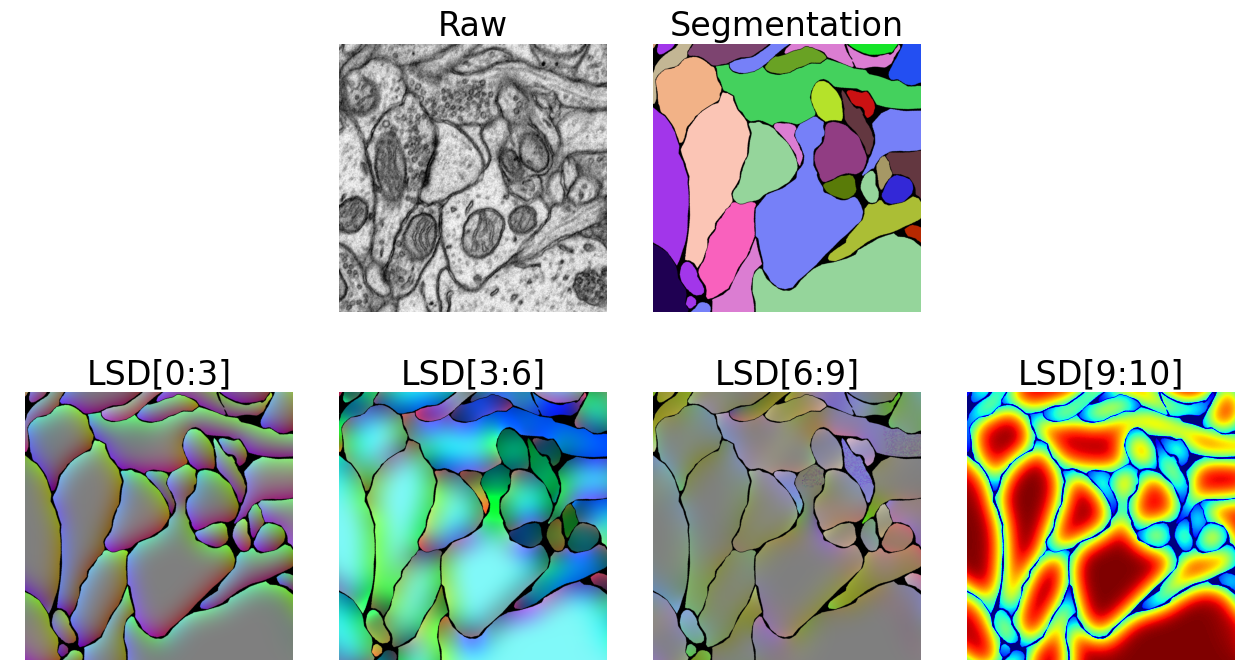

In [82]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

plt.subplots_adjust(wspace=0.05, hspace=0.3)
title_fontsize=24

axes[0, 0].axis('off')
# Row 1: Raw tensor and Labels tensor
axes[0, 1].imshow(raw[0, 20], cmap="gray")
axes[0, 1].set_title('Raw', fontsize=title_fontsize)
axes[0, 1].axis('off')

axes[0, 2].imshow(label2rgb(labels[20],bg_label=0,colors=random_colors), cmap=cmap, norm=norm)
axes[0, 2].set_title('Segmentation', fontsize=title_fontsize)
axes[0, 2].axis('off')

# Empty plots to align with the second row
axes[0, 3].axis('off')

# Row 2: Original LSD slices
axes[1, 0].imshow(lsd[0:3, 20].transpose(1, 2, 0))
axes[1, 0].set_title('LSD[0:3]', fontsize=title_fontsize)
axes[1, 0].axis('off')

axes[1, 1].imshow(lsd[3:6, 20].transpose(1, 2, 0))
axes[1, 1].set_title('LSD[3:6]', fontsize=title_fontsize)
axes[1, 1].axis('off')

axes[1, 2].imshow(lsd[6:9, 20].transpose(1, 2, 0))
axes[1, 2].set_title('LSD[6:9]', fontsize=title_fontsize)
axes[1, 2].axis('off')

axes[1, 3].imshow(lsd[9:10, 20].transpose(1, 2, 0), cmap="jet")
axes[1, 3].set_title('LSD[9:10]', fontsize=title_fontsize)
axes[1, 3].axis('off')

plt.show()
